In [33]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [4]:
FACE_MESH = pd.read_csv('mediaPipe/faceMesh/face_mesh.csv')

In [5]:
def landmarks_mapper(video: str):
    
    OPENFACE_DIR = 'openFace/processed/'
    MEDIAPIPE_DIR = 'mediaPipe/processed/'
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame']
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']]
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}']
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Pearson, MSE e CCC

In [13]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [14]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [16]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

In [17]:
videos = []
videos_pearson = []
videos_mse = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'ccc': videos_ccc})
extracted_features_df

,video,pearson,mse,ccc
0,whack_your_boss_12,0.994929,8.845432,0.973614
1,happy_wheels_54,0.982861,183.335608,0.974229
2,would_you_rather_29,0.996142,15.780578,0.976429
3,play_red_dead_138,0.843837,174.658153,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.975390
...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.982836
612,qwop_38,0.984433,41.320343,0.932025
613,cuphead_58,0.992749,22.439067,0.974880


In [21]:
%store extracted_features_df
%store -r extracted_features_df
extracted_features_df

Stored 'extracted_features_df' (DataFrame)


,video,pearson,mse,ccc
0,whack_your_boss_12,0.994929,8.845432,0.973614
1,happy_wheels_54,0.982861,183.335608,0.974229
2,would_you_rather_29,0.996142,15.780578,0.976429
3,play_red_dead_138,0.843837,174.658153,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.975390
...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.982836
612,qwop_38,0.984433,41.320343,0.932025
613,cuphead_58,0.992749,22.439067,0.974880


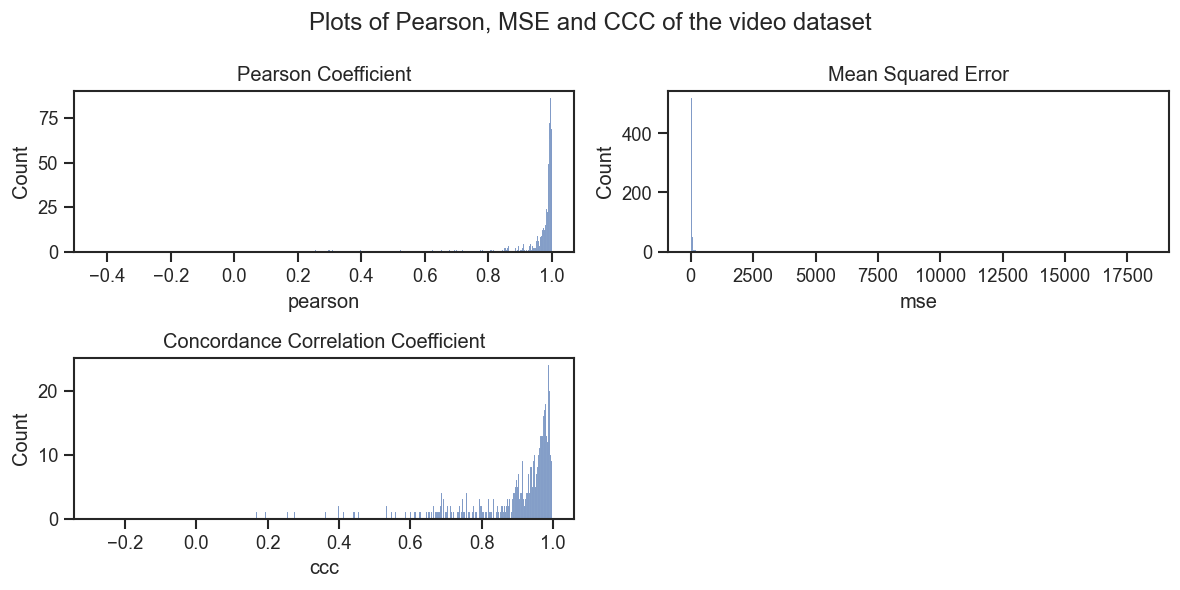

In [50]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, MSE and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df, x='mse', bins=615, ax=axes[1])

# CCC
axes[2].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df, x='ccc', bins=615, ax=axes[2])

fig.delaxes(axes[3])
fig.tight_layout()
plt.show()

In [71]:
df = extracted_features_df[extracted_features_df.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 19


,video,pearson
105,gta2_2,-0.433737
605,gta1_1,0.062133
145,qwop_40,0.255495
87,david_bowie_36,0.297967
490,qwop_93,0.300300
243,david_bowie_109,0.307798
373,gta2_26,0.396666
186,david_bowie_13,0.508014
408,fatality_17,0.523069
367,play_lastofus_202,0.572700


In [78]:
df = extracted_features_df[extracted_features_df.mse > 50].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con mse maggiore di 500:', len(df))
df

Numero di video con mse maggiore di 500: 63


,video,pearson,mse,ccc
602,happy_wheels_34,0.992220,50.653865,0.982506
155,gta1_46,0.894140,50.723861,0.756968
40,gta1_28,0.986668,51.740916,0.949385
323,qwop_21,0.906549,51.906705,0.804169
222,play_road_redemp_57,0.936659,52.183573,0.865981
...,...,...,...,...
243,david_bowie_109,0.307798,6122.133418,0.254961
145,qwop_40,0.255495,9328.441233,0.195560
605,gta1_1,0.062133,12119.516621,0.009935
105,gta2_2,-0.433737,13581.747217,-0.279235


In [79]:
df = extracted_features_df[extracted_features_df.ccc < 0.8].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 98


,video,pearson,mse,ccc
105,gta2_2,-0.433737,13581.747217,-0.279235
605,gta1_1,0.062133,12119.516621,0.009935
87,david_bowie_36,0.297967,18250.447875,0.166869
145,qwop_40,0.255495,9328.441233,0.195560
243,david_bowie_109,0.307798,6122.133418,0.254961
...,...,...,...,...
3,play_red_dead_138,0.843837,174.658153,0.796190
218,heartbeat_23,0.967683,28.464342,0.797000
84,play_lastofus_146,0.956649,18.231752,0.798034
484,battlefield1_25,0.950067,108.094772,0.799125


In [80]:
videos_low_pearson.intersection(videos_low_mse).intersection(videos_low_ccc)

{'battlefield1_50',
 'david_bowie_109',
 'david_bowie_13',
 'david_bowie_36',
 'eminem_142',
 'fatality_15',
 'fatality_17',
 'fatality_9',
 'gta1_1',
 'gta1_34',
 'gta2_2',
 'gta2_26',
 'happy_wheels_97',
 'play_lastofus_202',
 'qwop_40',
 'qwop_93'}